In [2]:
pip install datasets

In [3]:
from datasets import list_datasets,load_dataset

all_datasets = list_datasets()

<ipython-input-3-dbd9d5eaddf6>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


In [4]:
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 85497 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
emotions = load_dataset("emotion")

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]

In [8]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
train_ds[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3]}

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
import pandas as pd

emotions.set_format(type = "pandas")

In [12]:
df = emotions["train"][:]

In [13]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
#Converting labels from integer to Strings

def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

In [15]:
df["label_name"] = df["label"].apply(label_int2str)

In [16]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: >

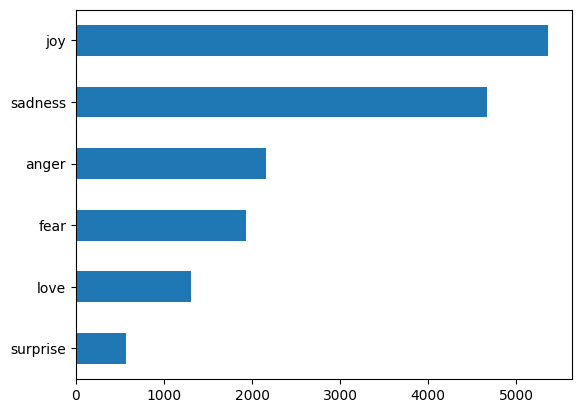

In [17]:
df['label_name'].value_counts(ascending = True).plot.barh()

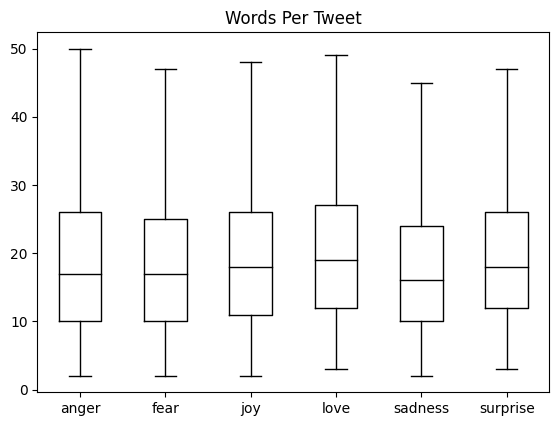

In [18]:
import matplotlib.pyplot as plt
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

 As it looks like there are mostly 15 words per tweet if more than that we need to trunicate it in tokenizer but it can lead to loss of information if contains crucial information.And we will reset the format of the Dataset to Default(Apache Arrow).

In [19]:
emotions.reset_format()

As we will be using DistilBERT for the model and it assume than the input is already been tokenized and enocoded in vectors.So Tokenization will be next process.

In [20]:
!pip install transformers

In [21]:
from transformers import AutoTokenizer

In [22]:
text = "Welcome to the NLP Tokenization we are glad"

In [23]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 6160, 2000, 1996, 17953, 2361, 19204, 3989, 2057, 2024, 5580, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Now that we have the input_ids, we can convert them back
into tokens by using the tokenizer’s "convert_ids_to_tokens()" method

In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [26]:
tokens

['[CLS]',
 'welcome',
 'to',
 'the',
 'nl',
 '##p',
 'token',
 '##ization',
 'we',
 'are',
 'glad',
 '[SEP]']

In [27]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] welcome to the nlp tokenization we are glad [SEP]


In [28]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object

In [29]:
def tokenize(batch):
  return tokenizer(batch["text"],padding =True,truncation = True)

#padding=True will pad the examples with zeros to the size of the longest one in a batch

emotions_encoded = emotions.map(tokenize,batch_size =None,batched = True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Now We will Train the model by two Ways:
1. We will use hidden layers as feature (freezing all hyperparameter of the model and freeze body weights during training.This approach is good as we have a small or shallow model as a refrence.

2. Fine tune it from end to end.

In [30]:
#First Approach using pretrained model as it is.

from transformers import AutoModel
import torch

model_cpkt = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_cpkt).to(device)


In [31]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [32]:
inputs = {
    k:v.to(device) for k,v in inputs.items()
}

with torch.no_grad():
  output = model(**inputs)
print(output)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


**Moving Tensors to a Device (v.to(device)):**

The line v.to(device) is used to move each tensor v in the inputs dictionary to the specified device (device)

Why: In deep learning, especially with neural network models, computations can be significantly accelerated on GPUs

**with torch.no_grad():**

This is to disable the gradient calculation in model as we are not training the model so there no need and the consumption of memory is saved.



In our example, the model output is an
instance of BaseModelOutput, and we can simply access its attributes by name. The
current model returns only one attribute, which is the last hidden state, so let’s examine
its shape:

In [33]:
output.last_hidden_state.size()

torch.Size([1, 6, 768])

In [34]:
output.last_hidden_state[:,0].size()
torch.Size([1, 768])

torch.Size([1, 768])

** Last Hidden State** is the entire learning or the interpretation of the input sequence its trained on we need to extact these learnings as features and load out input for the training.

In [35]:
#Now for the Whole Dataset
import torch

def extract_hidden_state(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
- This line converts the input data in the batch dictionary to the specified device and filters out keys that are not in the model's input names.

Computing Last Hidden State:

with torch.no_grad():
- This context manager ensures that no gradients are calculated during this block of code, which is useful for inference to save memory.


last_hidden_state = model(**inputs).last_hidden_state:
- This line passes the preprocessed inputs to the model and extracts the last hidden state.
Return Statement:

return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}:
- The function returns a dictionary containing the extracted last hidden state as a NumPy array. The .cpu() is used to move the tensor back to the CPU if it was processed on a GPU.
In summary, this function is designed to take a batch of input data, process it through a pre-trained transformer-based NLP model, and return the last hidden state as a NumPy array.


**The only difference between this function and our previous logic is the final step
where we place the final hidden state back on the CPU as a NumPy array. The map()
method requires the processing function to return Python or NumPy objects when
we’re using batched inputs.**

Since our model expects tensors as inputs, the next thing to do is convert the
input_ids and attention_mask columns to the "torch" format, as follows:

In [36]:
emotions_encoded.set_format("torch",columns = ["input_ids","attention_mask","label"])

In [37]:
emotions_hidden = emotions_encoded.map(extract_hidden_state,batched = True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [38]:
#Extra layer of hidden state is added in emotion hidden data
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

**Creating Train and Test Data**

In [39]:
import numpy as np
#as hidden_state extracted from transformer for custom data used as features for predictions
# Label of emotions are our target
X_train = np.array(emotions_hidden["train"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
X_val = np.array(emotions_hidden["validation"]["hidden_state"])
y_val = np.array(emotions_hidden["validation"]["label"])

In [40]:
X_train.shape, X_val.shape

((16000, 768), (2000, 768))

Visualizing the Distributions of target by UMAP.For UMAP its should be normalized first.

visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
use the powerful UMAP algorithm to project the vectors down to 2D. Since UMAP
works best when the features are scaled to lie in the [0,1] interval

In [41]:
!pip install umap-learn



In [42]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [43]:
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.158333,5.827051,0
1,-2.992687,4.999093,0
2,5.389902,2.629683,3
3,-2.329364,2.889181,2
4,-3.233184,3.121381,3


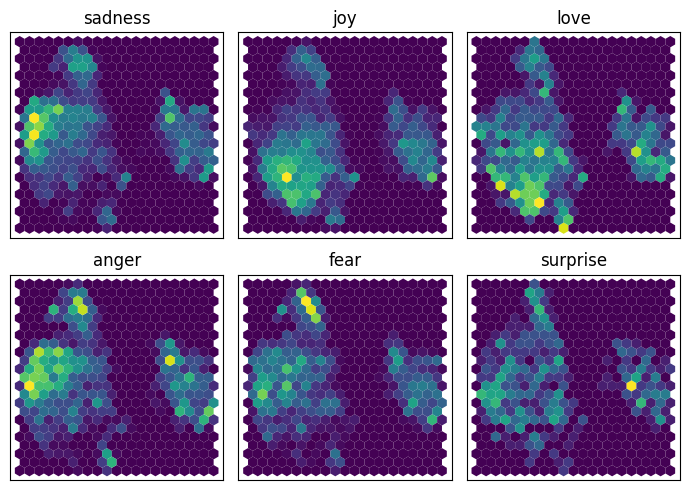

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],
                gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

These are only projections onto a lower-dimensional space. Just
because some categories overlap does not mean that they are not
separable in the original space. Conversely, if they are separable in
the projected space they will be separable in the original space.


From this plot we can see some clear patterns: the negative feelings such as sadness,
anger, and fear all occupy similar regions with slightly varying distributions. On the
other hand, joy and love are well separated from the negative emotions and also
share a similar space. Finally, surprise is scattered all over the place. Although we
may have hoped for some separation, this is in no way guaranteed since the model
was not trained to know the difference between these emotions. It only learned them
implicitly by guessing the masked words in texts.

Now from the hidden states we can train a base model which doesnot require GPU.Like Logistic for multiclass output.

In [45]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(max_iter=3000)

lg_clf.fit(X_train,y_train)
y_pred = lg_clf.predict(X_val)

In [46]:
lg_clf.score(X_val, y_val)

0.633

In [47]:
from sklearn.dummy import DummyClassifier

In [48]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
y_pred = dummy_clf.predict(X_val)
dummy_clf.score(X_val,y_val)

0.352

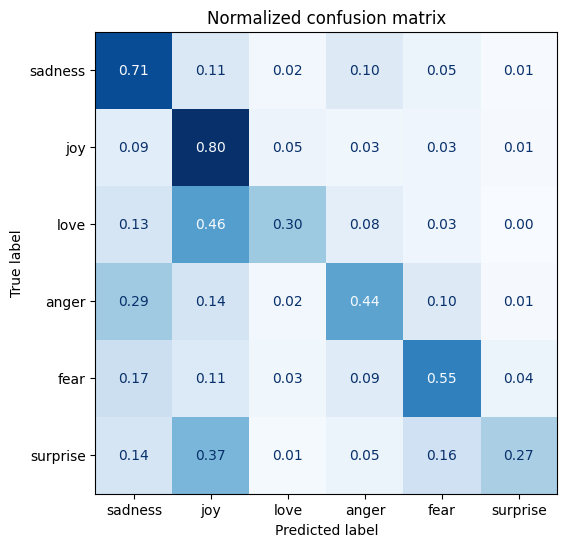

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lg_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val, labels)

**Lets Now Explore the Fine Tuning of the DistilBERT**
- In the fine tuning we dont use hidden state as a feature but train them for the appropriate data.

**Loading the Pretrained Model by AutoModelForSequenceClassification**
- The only difference between AutoModel and AutoModelForSequenceClassification that the latter has classification head on top of the pretrained outputs which can be trained easily as base model.We just need to specify the number of outputs we need for the prediction.(in our case 6)

In [50]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model = (AutoModelForSequenceClassification.from_pretrained(model_cpkt,num_labels = num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**To monitor Metrics we need to define the performance Metrics**

In [71]:
from sklearn.metrics import f1_score,accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


In [63]:
from huggingface_hub import notebook_login
notebook_login()

**To define the training parameters we us TrainingArgument class.**

- This class
stores a lot of information and gives you fine-grained control over the training and
evaluation. The most important argument to specify is **output_dir**, which is where
all the artifacts from training are stored

In [64]:
!pip install accelerate -U

In [57]:
#pip install transformers[torch]>=4.9.2 accelerate>=0.20.1


In [58]:
!pip cache purge
!pip install accelerate>=0.20.1

!pip install transformers[torch]>=4.9.2

Files removed: 1


In [68]:
!$huggingface-cli login

/bin/bash: line 1: -cli: command not found


In [69]:
from huggingface_hub import login
login()

In [73]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
num_train_epochs=6,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=logging_steps,
push_to_hub=True,
log_level="error")

trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.108500,0.205010,0.928500,0.929334
2,0.092900,0.195716,0.928000,0.928219
3,0.084600,0.170852,0.929000,0.928921
4,0.067300,0.190724,0.930000,0.929325
5,0.052300,0.188435,0.932500,0.932641
6,0.041200,0.194307,0.927500,0.927666


TrainOutput(global_step=1500, training_loss=0.0744695790608724, metrics={'train_runtime': 735.1156, 'train_samples_per_second': 130.592, 'train_steps_per_second': 2.04, 'total_flos': 2161028585088000.0, 'train_loss': 0.0744695790608724, 'epoch': 6.0})

- **batch_size = 64:** This sets the batch size, representing the number of training examples used in one iteration of model training.

- **logging_steps** = len(emotions_encoded["train"]) // batch_size: This calculates the number of training steps at which to log information during training. It divides the total number of training examples by the batch size to determine how many batches constitute one epoch.

- **TrainingArguments** is a class from the transformers library that holds the configuration for training a model.

- **output_dir**: Specifies the directory where the trained model and logs will be saved.

- **num_train_epochs=2**: This sets the number of times the model will go through the entire training dataset during the training process to 2 epochs. In other words, the model will be exposed to the entire training dataset twice.


- **per_device_train_batch_size**: Batch size per GPU or CPU during training.
- **per_device_eval_batch_size**: Batch size per GPU or CPU during evaluation.


- **weight_decay** parameter is a regularization technique commonly used during the training of machine learning models, including neural networks. It is a form of *L2 regularization* that is applied to the weights of the model. The purpose of weight decay is to prevent overfitting and improve the generalization performance of the model on unseen data.
During training, the model not only tries to minimize the loss on the training data but also aims to keep the weights small. This helps prevent the model from becoming too complex and overfitting the training data.



- **evaluation_strategy** parameter allows you to define when the evaluation should occur. In your case, it's set to "epoch", which means that the model will be evaluated once at the end of each training epoch.

Other common options include:

- **"steps"**: Evaluate the model at specified steps (specified by eval_steps parameter).
- **"no"**: Disable automatic evaluation during training. You would need to handle evaluation manually.

Evaluating at the end of each epoch is a practical choice, as it provides a balance between frequent monitoring of the model's progress and computational efficiency. It allows you to observe how the model is performing on the validation set after it has seen the entire training dataset.


- **logging_steps**: Specifies how often to log training information.
- **push_to_hub**: If True, pushes the model and training artifacts to the Hugging Face Model Hub.
- **log_level:** Sets the logging level.

In [77]:
#Prediction
pred_output = trainer.predict(emotions_encoded["validation"])

In [79]:
pred_output.metrics

{'test_loss': 0.19430747628211975,
 'test_accuracy': 0.9275,
 'test_f1': 0.927665683146172,
 'test_runtime': 4.021,
 'test_samples_per_second': 497.386,
 'test_steps_per_second': 7.958}

In [80]:
#It also contains the raw predictions for each class. We can decode the predictions greedily using np.argmax()

y_pred = np.argmax(pred_output.predictions,axis=1)

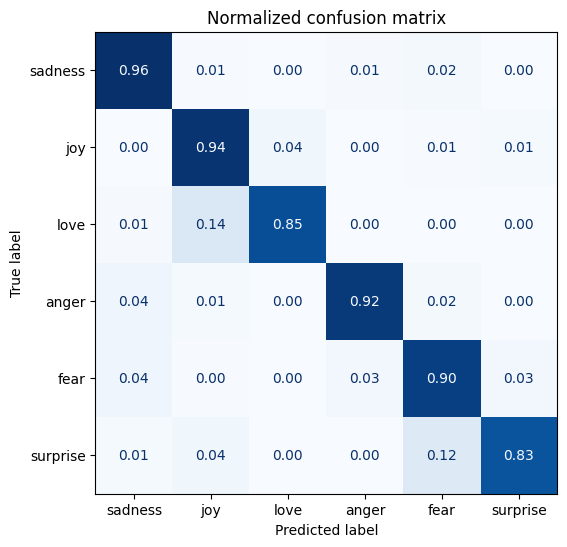

In [82]:
plot_confusion_matrix(y_pred, y_val, labels)

This is close to Ideal predictions though the Joy are still getting confused as love.

**Fine Tuning With Keras**

The Main Difference between PyTorch API and Keras API is that trainer class is absent in Keras,since it has built-in fit() method.Its as follows:

In [94]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels))

Now we wil convert our dataset in tf.data.Dataset format.Because we have already padded our data in our tokenized inputs.we can do this conversion easily by applying the
**to_tf_dataset()** method to emotions_encoded:

In [90]:
#Getting Tokenizer Columns

tokenizer_columns = tokenizer.model_input_names

In [95]:
#Training and Testing Data in TensorFlow
import tensorflow as tf
tf_train_dataset =emotions_encoded["train"].to_tf_dataset(columns = tokenizer_columns,label_cols = ["label"],
                                           shuffle = True,batch_size = batch_size)

tf_eval_dataset =emotions_encoded["validation"].to_tf_dataset(columns = tokenizer_columns,label_cols = ["label"],
                                           shuffle = True,batch_size = batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [98]:
#Now that we have shuffled the data and defined train and validations
#Its time to compile and train

tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = tf.metrics.SparseCategoricalAccuracy()
)

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 177s 527ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.1810 - val_sparse_categorical_accuracy: 0.9290
Epoch 2/2
250/250 [==============================] - 134s 535ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.1453 - val_sparse_categorical_accuracy: 0.9340
